In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
from tqdm.notebook import tqdm
import zipfile

In [2]:
sz = 512   #the size of tiles
reduce = 2 #reduce the original images by 4 times 
MASKS = '../Project/data/train.csv'
DATA = '../Project/data/train/'
OUT_TRAIN = 'train.zip'
OUT_MASKS = 'masks.zip'

In [3]:
#functions to convert encoding to mask and mask to encoding
def enc2mask(encs, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

df_masks = pd.read_csv(MASKS).set_index('id')
df_masks.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...


In [ ]:
s_th = 40  #saturation blancking threshold
p_th = 200*sz//256 #threshold for the minimum number of pixels

x_tot,x2_tot = [],[]
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index, encs in tqdm(df_masks.iterrows(),total=len(df_masks)):
        #read image and generate the mask
        img = tiff.imread(os.path.join(DATA,index+'.tiff'))
        if len(img.shape) == 5: img = np.transpose(img.squeeze(), (1,2,0))
        mask = enc2mask(encs,(img.shape[1],img.shape[0]))

        #add padding to make the image dividable into tiles
        shape = img.shape
        pad0 = (reduce*sz - shape[0]%(reduce*sz))%(reduce*sz)
        pad1 = (reduce*sz - shape[1]%(reduce*sz))%(reduce*sz)
        img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                    constant_values=0)
        mask = np.pad(mask,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2]],
                    constant_values=0)

        #split image and mask into tiles using the reshape+transpose trick
        img = cv2.resize(img,(img.shape[1]//reduce,img.shape[0]//reduce),
                         interpolation = cv2.INTER_AREA)
        img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
        img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

        mask = cv2.resize(mask,(mask.shape[1]//reduce,mask.shape[0]//reduce),
                          interpolation = cv2.INTER_NEAREST)
        mask = mask.reshape(mask.shape[0]//sz,sz,mask.shape[1]//sz,sz)
        mask = mask.transpose(0,2,1,3).reshape(-1,sz,sz)

        #write data
        for i,(im,m) in enumerate(zip(img,mask)):
            #remove black or gray images based on saturation check
            hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            if (s>s_th).sum() <= p_th or im.sum() <= p_th: continue
            
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{i}.png', im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{i}.png', m)

#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

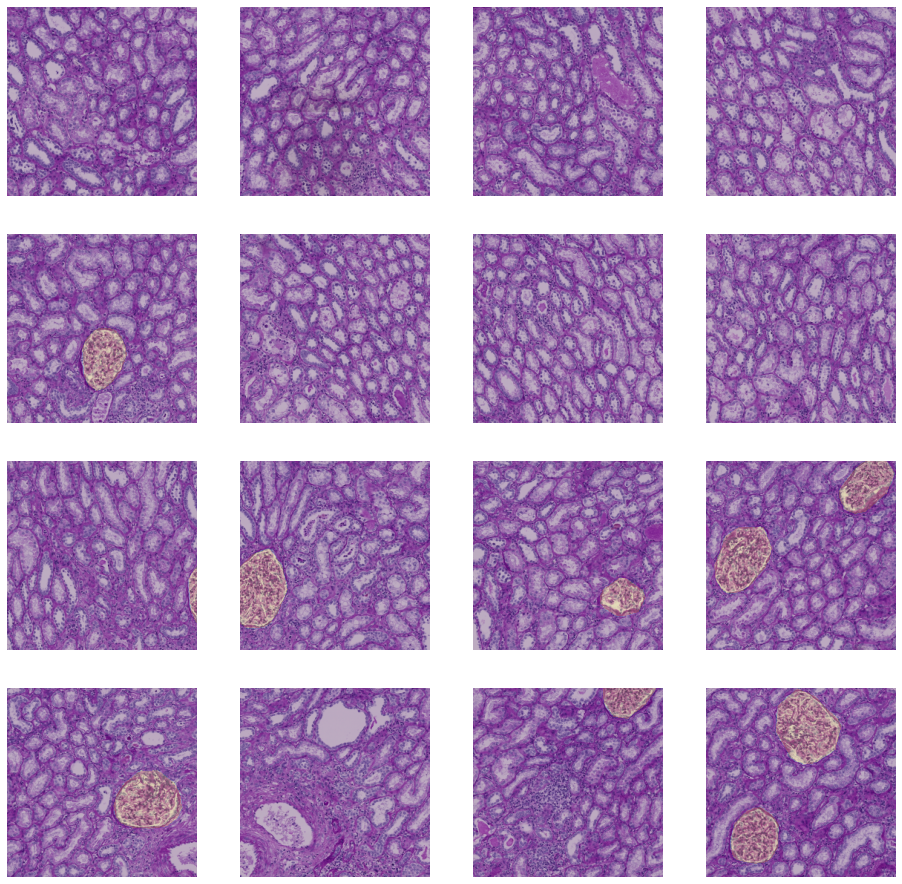

In [5]:
columns, rows = 4,4
idx0 = 20
fig=plt.figure(figsize=(columns*4, rows*4))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())[8:]
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.2)
plt.show()

In [8]:
import zipfile
with zipfile.ZipFile("../Project/masks.zip", 'r') as zip_ref:
    zip_ref.extractall('../Project/data/mask_256')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c5aa932a-5c34-48e2-be33-10614017587c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>